In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/viktor/mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-16 17:54:10,973 INFO: Initializing external client
2025-11-16 17:54:10,974 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 17:54:12,348 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296538


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-16 17:54:14,400 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [6]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [7]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


In [9]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2022-09-02 00:00:00+00:00,11.603000,0.0,9.726665,70.016815
1,2022-09-03 00:00:00+00:00,11.686333,1.9,9.826088,122.768501
2,2022-09-04 00:00:00+00:00,12.311333,0.7,10.972620,84.829025
3,2022-09-05 00:00:00+00:00,11.655086,0.2,10.661107,90.389740
4,2022-09-06 00:00:00+00:00,12.611333,0.0,10.787993,253.386459
...,...,...,...,...,...
950,2025-04-26 00:00:00+00:00,6.425916,0.0,17.604149,217.002579
951,2025-04-27 00:00:00+00:00,9.294666,0.0,21.691305,243.177032
952,2025-04-28 00:00:00+00:00,12.359250,0.0,33.502251,254.300140
953,2025-04-29 00:00:00+00:00,12.700917,0.0,22.197729,278.306610


In [10]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [11]:
y_train

,pm25
0,12.0
1,7.0
2,11.0
3,12.0
4,14.0
...,...
950,12.0
951,21.0
952,44.0
953,25.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [12]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 135.0145
R squared: -0.035178873044945824


In [14]:
df = y_test.copy()
df['predicted_pm25'] = y_pred

In [15]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
955,19.0,23.702408,2025-05-01 00:00:00+00:00
956,34.0,30.858383,2025-05-02 00:00:00+00:00
957,19.0,25.833790,2025-05-03 00:00:00+00:00
958,9.0,12.740001,2025-05-04 00:00:00+00:00
959,14.0,19.458109,2025-05-05 00:00:00+00:00


In [16]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

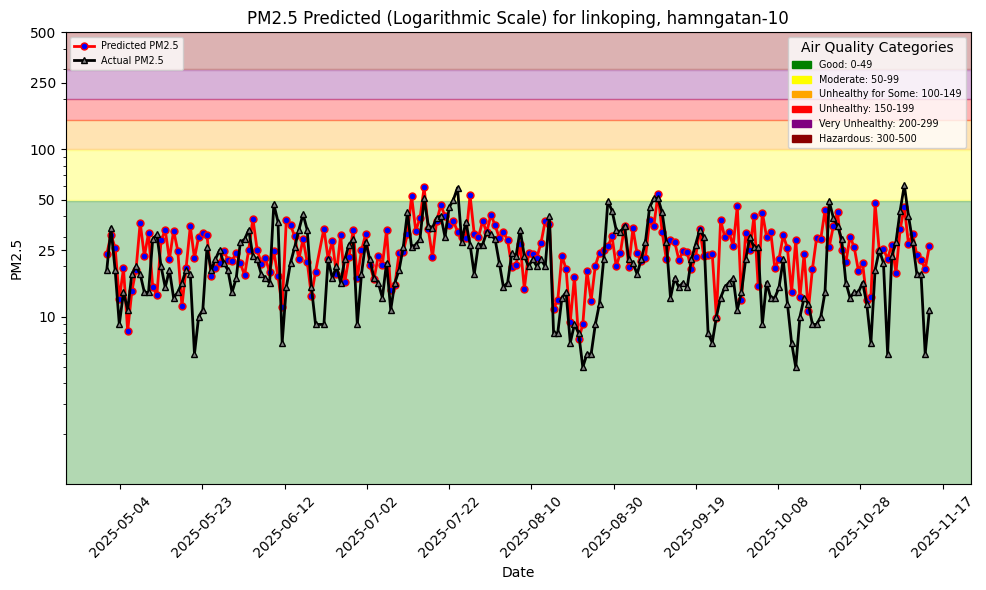

In [17]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

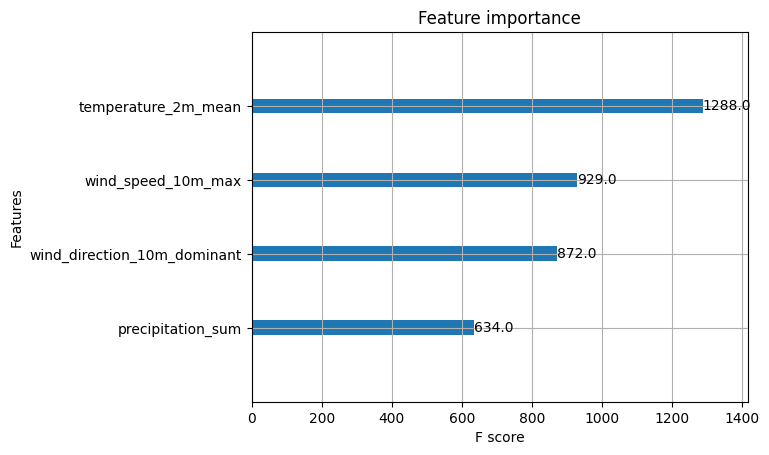

In [18]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [19]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [20]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [21]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

#commented this part out and put it on the bottom as to include the more detailed metrics which we only compute later!
"""aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)"""

'aq_model = mr.python.create_model(\n    name="air_quality_xgboost_model", \n    metrics= res_dict,\n    feature_view=feature_view,\n    description="Air Quality (PM2.5) predictor",\n)\n\n# Saving the model artifacts to the \'air_quality_model\' directory in the model registry\naq_model.save(model_dir)'

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.


In [22]:
#Adding code for the C-part:

air_quality_fg_v2 = fs.get_feature_group(
    name='air_quality',
    version=2,
)

selected_features_lag = air_quality_fg_v2.select(['pm25', 'date', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3']).join(weather_fg.select_features(), on=['city'])

feature_view_lag = fs.get_or_create_feature_view(
    name='air_quality_fv_lag',
    description="weather + pm25 lag1/2/3 with pm25 as target",
    version=1,
    labels=['pm25'],
    query=selected_features_lag,
)

X_train_lag, X_test_lag, y_train_lag, y_test_lag = feature_view_lag.train_test_split(
    test_start=test_start
)

X_train_lag

2025-11-16 17:54:26,035 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1296538/fs/1284171/fv/air_quality_fv_lag/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.66s) 


,date,pm25_lag1,pm25_lag2,pm25_lag3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2022-09-05 00:00:00+00:00,11.0,7.0,12.0,11.655086,0.2,10.661107,90.389740
1,2022-09-06 00:00:00+00:00,12.0,11.0,7.0,12.611333,0.0,10.787993,253.386459
2,2022-09-07 00:00:00+00:00,14.0,12.0,11.0,12.340500,0.1,14.058450,104.349426
3,2022-09-08 00:00:00+00:00,14.0,14.0,12.0,11.363416,0.6,19.386593,84.588966
4,2022-09-09 00:00:00+00:00,9.0,14.0,14.0,14.023831,0.2,26.183659,100.786736
...,...,...,...,...,...,...,...,...
947,2025-04-26 00:00:00+00:00,10.0,13.0,45.0,6.425916,0.0,17.604149,217.002579
948,2025-04-27 00:00:00+00:00,12.0,10.0,13.0,9.294666,0.0,21.691305,243.177032
949,2025-04-28 00:00:00+00:00,21.0,12.0,10.0,12.359250,0.0,33.502251,254.300140
950,2025-04-29 00:00:00+00:00,44.0,21.0,12.0,12.700917,0.0,22.197729,278.306610


In [23]:
X_train_lag_features = X_train_lag.drop(columns=['date'])
X_test_lag_features = X_test_lag.drop(columns=['date'])
y_train_lag

,pm25
0,12.0
1,14.0
2,14.0
3,9.0
4,19.0
...,...
947,12.0
948,21.0
949,44.0
950,25.0


In [24]:
#Modeling:
xgb_regressor_lag = XGBRegressor()
xgb_regressor_lag.fit(X_train_lag_features, y_train_lag)

y_pred_lag = xgb_regressor_lag.predict(X_test_lag_features)

mse_lag = mean_squared_error(y_test_lag.iloc[:,0], y_pred_lag)
print("Lag model MSE:", mse_lag)

r2_lag = r2_score(y_test_lag.iloc[:,0], y_pred_lag)
print("Lag model R squared:", r2_lag)

Lag model MSE: 76.43978
Lag model R squared: 0.41485470645763767


In [25]:
#Now we need to evaluate!!!
df_test = X_test_lag.copy()

df_test["pm25"] = y_test_lag["pm25"].values
df_test["date"] = pd.to_datetime(df_test["date"])  #In case we dont have correct date format already!

df_test = df_test.sort_values("date").reset_index(drop=True) #Want to remove possible weird old indexes.
df_test.head()


,date,pm25_lag1,pm25_lag2,pm25_lag3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25
0,2025-05-01 00:00:00+00:00,12.0,25.0,44.0,12.652999,0.0,18.533009,233.108292,19.0
1,2025-05-02 00:00:00+00:00,19.0,12.0,25.0,12.190499,0.3,34.292713,247.808929,34.0
2,2025-05-03 00:00:00+00:00,34.0,19.0,12.0,9.817583,0.3,20.886982,267.476074,19.0
3,2025-05-04 00:00:00+00:00,19.0,34.0,19.0,6.234250,1.4,27.834892,18.379606,9.0
4,2025-05-05 00:00:00+00:00,9.0,19.0,34.0,6.984250,0.0,23.749088,278.658752,14.0


In [26]:
baseline_feature_cols = list(X_features.columns)         
lag_feature_cols = list(X_train_lag_features.columns)

In [27]:
#we have to actually make prediction:
def forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags):
    predictions = []
    
    if use_lags: #establish a starting point (today!): 
        lag_1 = row_today['pm25']
        lag_2 = row_today['pm25_lag1']
        lag_3 = row_today['pm25_lag2']
        
    for h in range(max_horizon): #from tomorrow onwards: 
        row_to_predict = rows_to_predict.iloc[h].copy()
        
        if use_lags: #overwrite possible real values (which is illegal to use here) with predicted values!
            row_to_predict['pm25_lag1'] = lag_1
            row_to_predict['pm25_lag2'] = lag_2
            row_to_predict['pm25_lag3'] = lag_3
            
        X_row = row_to_predict[feature_cols].values.reshape(1, -1)
        y_pred = float(model.predict(X_row)[0])

        predictions.append(y_pred)
        if use_lags:
            #push all lags back because we move forward one day:
            lag_3 = lag_2 
            lag_2 = lag_1
            lag_1 = y_pred

        
    return predictions

# Compute MSE1,...,MSE7:
def hindcast_recursive(df, model, feature_cols, max_horizon=7, use_lags=False):
    target_col="pm25"
    df = df.sort_values("date").reset_index(drop=True)
    
    records= []
    
    for start_index in range(len(df) - max_horizon): #we dont want to 
        row_today = df.iloc[start_index].copy()
        rows_to_predict = df.iloc[start_index+1:start_index+1+max_horizon].copy()
        
        y_predictions = forecast_recursive(model, row_today, rows_to_predict, feature_cols, max_horizon, use_lags)

        #unpack all:
        for i in range(max_horizon):
            y_pred = y_predictions[i]
            target_row = rows_to_predict.iloc[i]
            y_true = float(target_row[target_col])

            records.append({
                "forecast_start_date": row_today['date'],
                "target_date": target_row['date'],
                "horizon": i+1,
                "y_true": y_true,
                "y_pred": y_pred,
            })


    return pd.DataFrame(records)

In [28]:
#first we have the baseline: 
hc_base = hindcast_recursive(
    df_test,
    model=xgb_regressor,
    feature_cols=baseline_feature_cols,
    max_horizon=7,
    use_lags=False,
)
#then the model with lag.
hc_lag = hindcast_recursive(
    df_test,
    model=xgb_regressor_lag,
    feature_cols=lag_feature_cols,
    max_horizon=7,
    use_lags=True,
)
def mse(group):
    return mean_squared_error(group.y_true, group.y_pred)
    
def mse_per_horizon(hc_df):

    return hc_df.groupby("horizon").apply(mse)

mse_base_h = mse_per_horizon(hc_base)
mse_lag_h = mse_per_horizon(hc_lag)

comparison = pd.DataFrame({
    "mse_baseline": mse_base_h,
    "mse_lag": mse_lag_h
})

comparison


,mse_baseline,mse_lag
horizon,,
1,136.683677,76.644250
2,136.684643,112.235270
3,136.588010,141.403799
4,136.592557,150.732543
5,137.357531,151.267613
6,139.107695,146.826014
7,140.739640,150.912236


In [29]:
#Now we need to save the model
res_dict_lag  = { 
        "MSE": str(mse_lag),
        "R squared": str(r2_lag),
    }

#per horizon:
for h, mse in mse_lag_h.items():
    res_dict_lag[f"MSE_h{h}"] = str(mse)

res_dict_lag

{'MSE': '76.43978',
 'R squared': '0.41485470645763767',
 'MSE_h1': '76.6442499552981',
 'MSE_h2': '112.23527041205641',
 'MSE_h3': '141.40379875715368',
 'MSE_h4': '150.73254348447713',
 'MSE_h5': '151.26761312937833',
 'MSE_h6': '146.82601408596295',
 'MSE_h7': '150.91223622034173'}

In [30]:
res_dict_base  = res_dict.copy()

for h, mse in mse_base_h.items():
    res_dict_base[f"MSE_h{h}"] = str(mse)

res_dict_base


{'MSE': '135.0145',
 'R squared': '-0.035178873044945824',
 'MSE_h1': '136.68367677130803',
 'MSE_h2': '136.68464256018802',
 'MSE_h3': '136.58801007286425',
 'MSE_h4': '136.5925572182352',
 'MSE_h5': '137.35753080737192',
 'MSE_h6': '139.1076947651875',
 'MSE_h7': '140.7396399351831'}

In [31]:
model_dir_lag = "air_quality_model_lag"
if not os.path.exists(model_dir_lag):
    os.mkdir(model_dir_lag)
images_dir = model_dir_lag + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)



In [32]:
#Images and stuff (replicating what exist for the base model):
df_lag = y_test_lag.copy()
df_lag['predicted_pm25'] = y_pred_lag    #This is only for a day ahead predictions i belive!

df_lag['date'] = X_test_lag['date']
df_lag = df_lag.sort_values(by=['date'])
df_lag.head(5)

,pm25,predicted_pm25,date
952,19.0,21.335707,2025-05-01 00:00:00+00:00
953,34.0,30.990776,2025-05-02 00:00:00+00:00
954,19.0,34.732716,2025-05-03 00:00:00+00:00
955,9.0,12.135111,2025-05-04 00:00:00+00:00
956,14.0,14.854650,2025-05-05 00:00:00+00:00


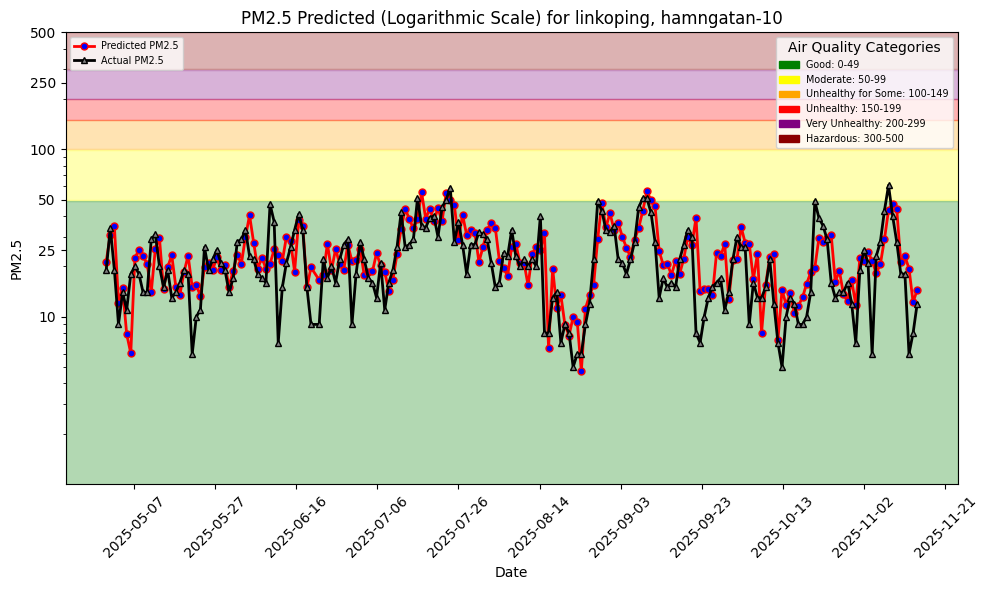

In [33]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df_lag, file_path, hindcast=True) 
plt.show()


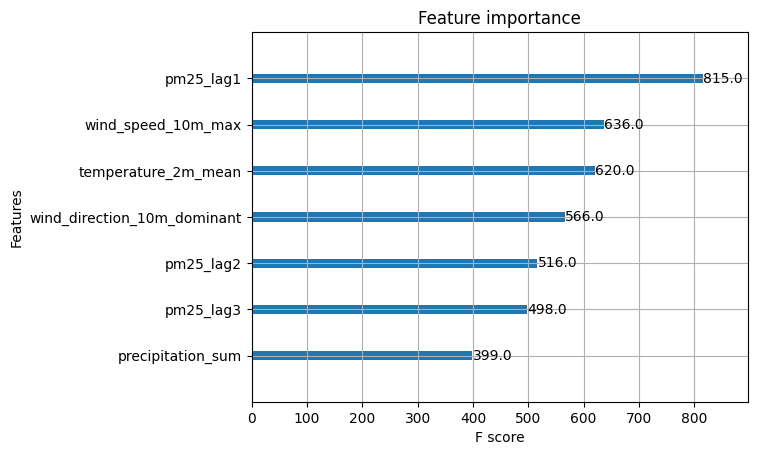

In [34]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor_lag)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [37]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor_lag.save_model(model_dir_lag + "/model.json")

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model_lag = mr.python.create_model(
    name="air_quality_xgboost_model_lag", 
    metrics= res_dict_lag,
    feature_view=feature_view_lag,
    description="Air Quality (PM2.5) predictor with lag pm25 values",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model_lag.save(model_dir_lag)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/viktor/mlfs-book/notebooks/airquality/air_quality_model_lag/model.json: 0.000%|          | 0/4…

Uploading /home/viktor/mlfs-book/notebooks/airquality/air_quality_model_lag/images/pm25_hindcast.png: 0.000%| …

Uploading /home/viktor/mlfs-book/notebooks/airquality/air_quality_model_lag/images/feature_importance.png: 0.0…

Uploading /home/viktor/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0/782 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296538/models/air_quality_xgboost_model_lag/1


Model(name: 'air_quality_xgboost_model_lag', version: 1)

In [38]:
#Now we want to add the evaluation data for the base model aswell:

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_base", 
    metrics= res_dict_base,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor (upgraded metrics)",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/viktor/mlfs-book/notebooks/airquality/air_quality_model/model.json: 0.000%|          | 0/43130…

Uploading /home/viktor/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hindcast.png: 0.000%|     …

Uploading /home/viktor/mlfs-book/notebooks/airquality/air_quality_model/images/feature_importance.png: 0.000%|…

Uploading /home/viktor/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|          | 0/572 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1296538/models/air_quality_xgboost_model_base/1


Model(name: 'air_quality_xgboost_model_base', version: 1)